# CV Screening

## 1. Import Libraries

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer   # 👈 Make sure this is here
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)
import sklearn

## 2. Load Dataset

In [39]:
file_path = r"C:\Users\bbuser\Desktop\Jupyter\Resume.csv"
df = pd.read_csv(file_path, encoding='utf-8')

print("✅ Dataset loaded successfully")
print("Shape:", df.shape)
df.head()


✅ Dataset loaded successfully
Shape: (2484, 4)


,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


## 3. EDA (Exploratory Data Analysis)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB


In [41]:
print("\nMissing values per column:\n", df.isnull().sum())


Missing values per column:
 ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64


In [42]:
print("\nUnique categories in target column:", df['Category'].unique())


Unique categories in target column: ['HR' 'DESIGNER' 'INFORMATION-TECHNOLOGY' 'TEACHER' 'ADVOCATE'
 'BUSINESS-DEVELOPMENT' 'HEALTHCARE' 'FITNESS' 'AGRICULTURE' 'BPO' 'SALES'
 'CONSULTANT' 'DIGITAL-MEDIA' 'AUTOMOBILE' 'CHEF' 'FINANCE' 'APPAREL'
 'ENGINEERING' 'ACCOUNTANT' 'CONSTRUCTION' 'PUBLIC-RELATIONS' 'BANKING'
 'ARTS' 'AVIATION']


In [43]:
df.describe()

,ID
count,2.484000e+03
mean,3.182616e+07
std,2.145735e+07
min,3.547447e+06
25%,1.754430e+07
50%,2.521031e+07
75%,3.611444e+07
max,9.980612e+07


In [44]:
df.dtypes

ID              int64
Resume_str     object
Resume_html    object
Category       object
dtype: object

In [45]:
#Check unique values for categorical columns
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: {df[col].nunique()} unique values")

Resume_str: 2482 unique values
Resume_html: 2482 unique values
Category: 24 unique values


In [46]:
# Check dataset shape
print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset has 2484 rows and 4 columns.


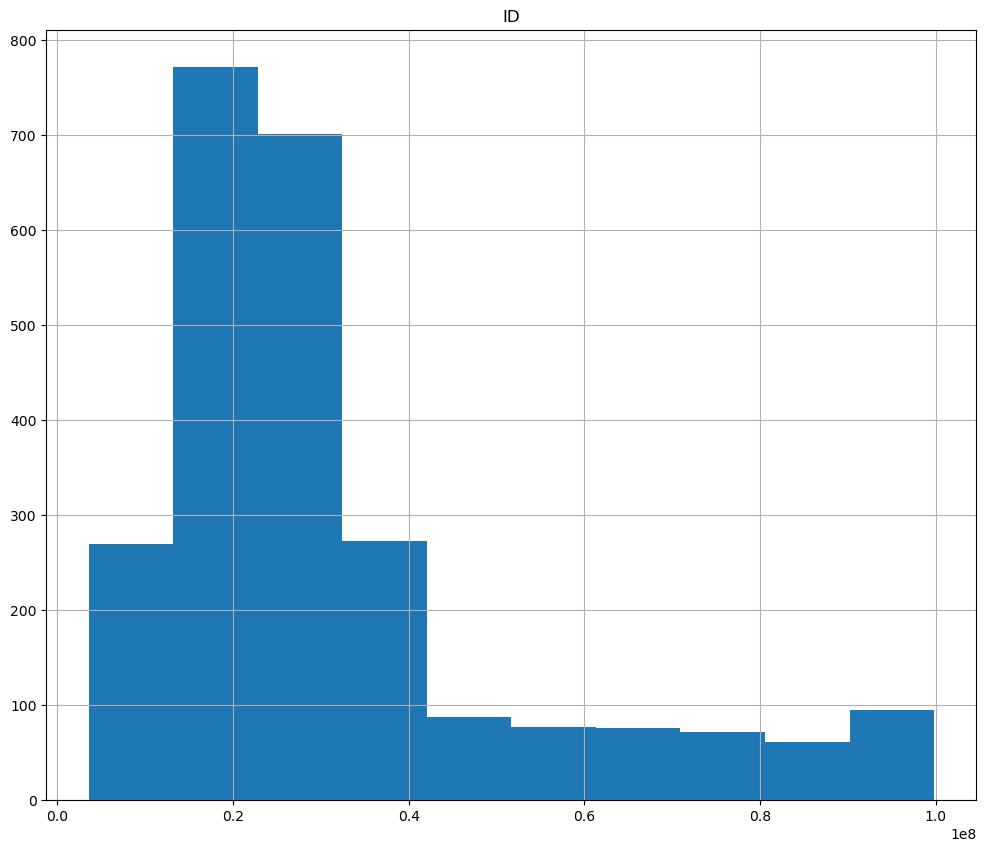

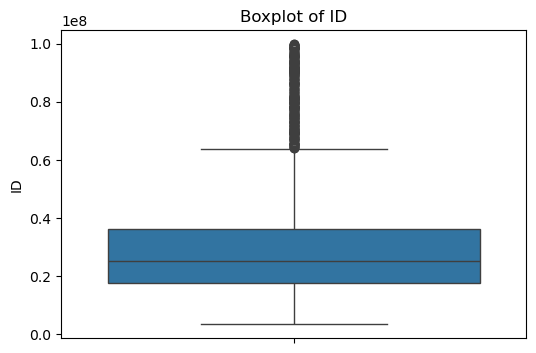

In [47]:
# Get numeric columns
num_cols = df.select_dtypes(include='number').columns.tolist()

# Histograms for numeric columns
df[num_cols].hist(figsize=(12,10))
plt.show()

# Boxplots for numeric columns
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

## 4. Basic Cleaning / Text Preprocessing

In [11]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r"https?://\S+|www\.\S+", " ", text)
    text = re.sub(r"\S+@\S+", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['Resume_str'] = df['Resume_str'].astype(str).apply(clean_text)

print("Sample cleaned resume:")
print(df['Resume_str'].head(3))

Sample cleaned resume:
0    hr administratormarketing associate hr adminis...
1    hr specialist us hr operations summary versati...
2    hr director summary over years experience in r...
Name: Resume_str, dtype: object


## 5. Visual EDA

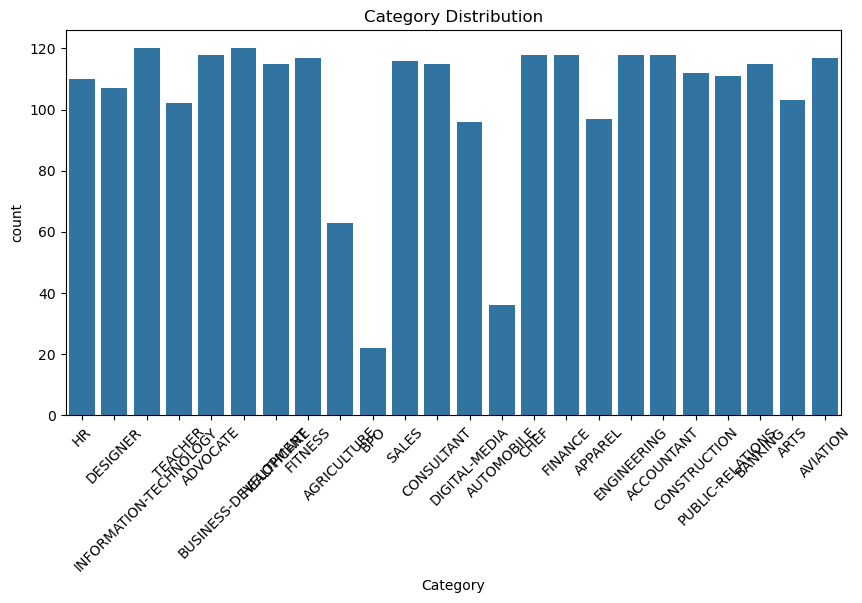

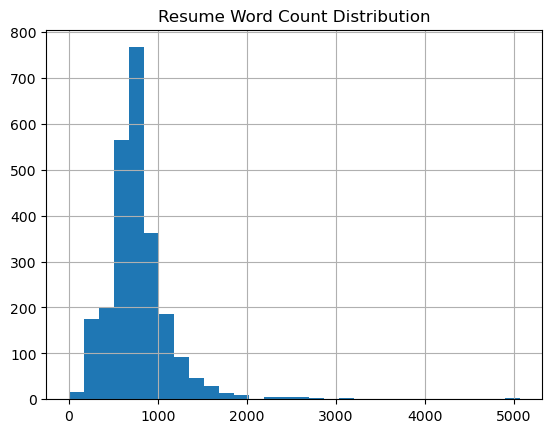

In [12]:
# Distribution of target categories
plt.figure(figsize=(10,5))
sns.countplot(x='Category', data=df)
plt.xticks(rotation=45)
plt.title('Category Distribution')
plt.show()

# Optional: Word count per resume
df['word_count'] = df['Resume_str'].apply(lambda x: len(x.split()))
df['word_count'].hist(bins=30)
plt.title('Resume Word Count Distribution')
plt.show()

## 6. Train / Test Split

In [13]:
X = df[['Resume_str']]  # feature (text)
y = df['Category']      # target (label)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (1987, 1)
Test size: (497, 1)


## 7. Text Encoding + Model Pipeline

In [14]:
# ColumnTransformer to apply OneHotEncoder / TF-IDF
# For text, it's usually better to use TF-IDF:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1,2),
    max_df=0.9,
    min_df=2
)

# We'll apply TF-IDF directly on Resume_str column
# ColumnTransformer expects column index or name
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf, 'Resume_str')
    ]
)

# Models to train
models = {
    "Logistic Regression": LogisticRegression(max_iter=300),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
}

## 8. Training & Evaluation

In [23]:
results = []

for name, model in models.items():
    clf = Pipeline(steps=[('preprocess', preprocessor),
                          ('model', model)])
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='weighted', zero_division=0
    )
    
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    })

results_df = pd.DataFrame(results).sort_values(by="F1", ascending=False)
results_df


=== Logistic Regression ===
Accuracy: 0.6499
Precision: 0.6729
Recall: 0.6499
F1-score: 0.6294

Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTANT       0.62      0.83      0.71        24
              ADVOCATE       0.34      0.46      0.39        24
           AGRICULTURE       1.00      0.23      0.38        13
               APPAREL       0.75      0.16      0.26        19
                  ARTS       0.67      0.29      0.40        21
            AUTOMOBILE       0.00      0.00      0.00         7
              AVIATION       0.81      0.71      0.76        24
               BANKING       0.88      0.65      0.75        23
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       0.49      0.92      0.64        24
                  CHEF       0.81      0.71      0.76        24
          CONSTRUCTION       0.81      0.77      0.79        22
            CONSULTANT       0.44      0.17    

,Model,Accuracy,Precision,Recall,F1
1,Random Forest,0.686117,0.688021,0.686117,0.654209
0,Logistic Regression,0.649899,0.672893,0.649899,0.629433


## 📊 Visualization Section

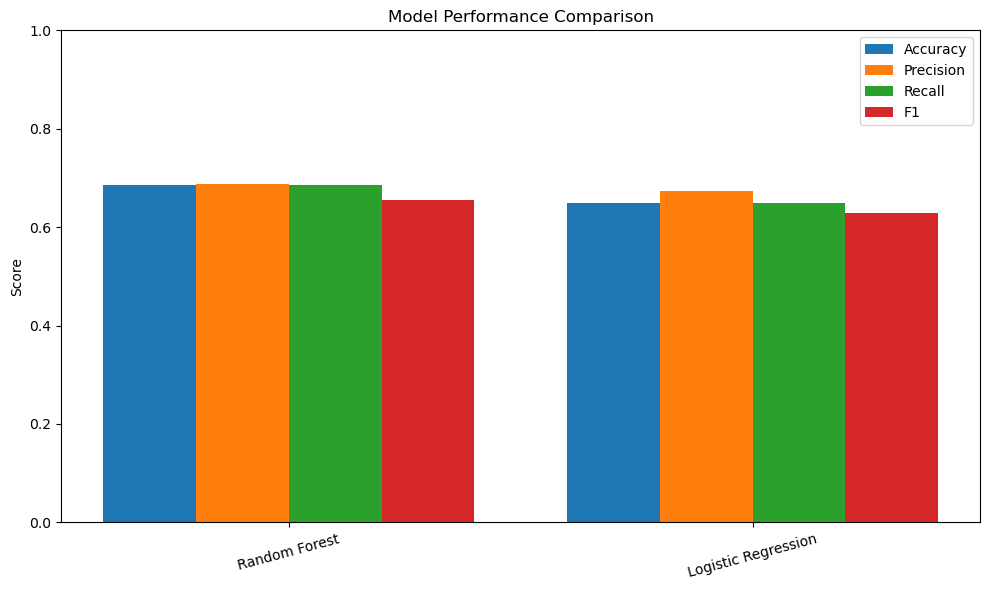

In [17]:
## Plot Model Performance (Accuracy / Precision / Recall / F1)
plt.figure(figsize=(10,6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']

# Plot each metric as a grouped bar
x = np.arange(len(results_df['Model']))
bar_width = 0.2

for i, metric in enumerate(metrics):
    plt.bar(x + i*bar_width, results_df[metric], width=bar_width, label=metric)

plt.xticks(x + bar_width * (len(metrics)-1)/2, results_df['Model'], rotation=15)
plt.ylabel('Score')
plt.ylim(0, 1.0)
plt.title('Model Performance Comparison')
plt.legend()
plt.tight_layout()
plt.show()

### 📈 F1 Score Comparison

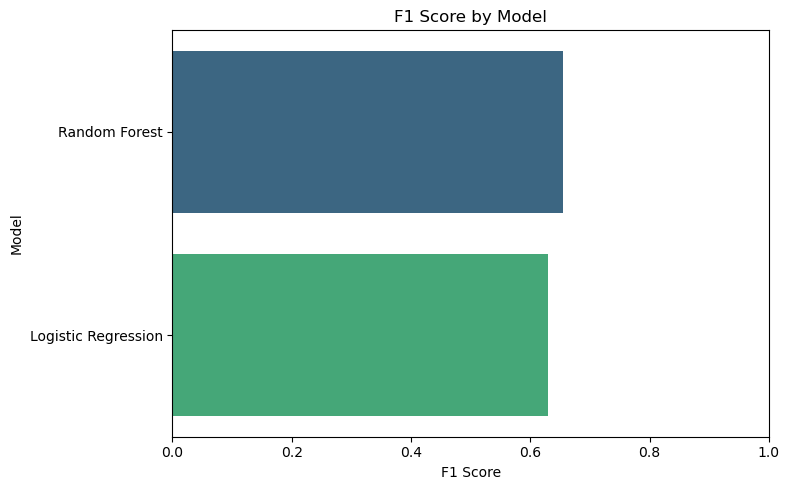

In [18]:
plt.figure(figsize=(8,5))
sns.barplot(x='F1', y='Model', data=results_df, palette='viridis')
plt.title('F1 Score by Model')
plt.xlabel('F1 Score')
plt.ylabel('Model')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

### Confusion Matrix Heatmaps (Per Model)

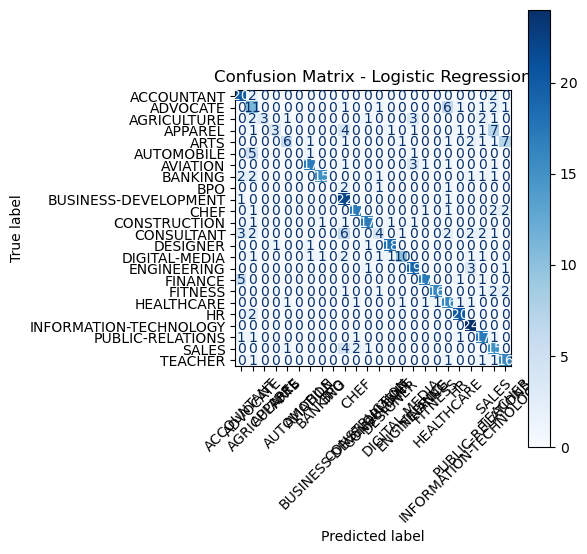

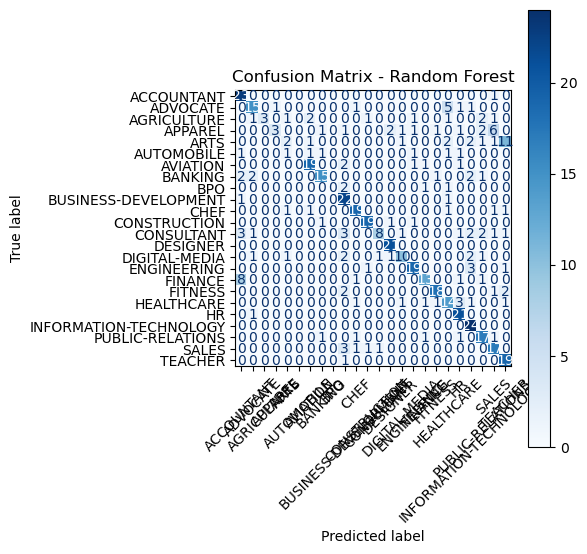

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

for name, model in models.items():
    clf = Pipeline(steps=[('preprocess', preprocessor),
                          ('model', model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    fig, ax = plt.subplots(figsize=(6,6))
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, ax=ax, cmap='Blues', xticks_rotation=45
    )
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()

## 9. Save Best Model (Optional)

In [16]:
import joblib
best_model_name = results_df.iloc[0]['Model']
best_pipeline = Pipeline(steps=[('preprocess', preprocessor),
                                ('model', models[best_model_name])])
best_pipeline.fit(X, y)

joblib.dump(best_pipeline, f"best_model_{best_model_name.replace(' ', '_')}.joblib")
print(f"✅ Best model ({best_model_name}) saved successfully.")

✅ Best model (Random Forest) saved successfully.
